<a href="https://colab.research.google.com/github/praneshdeshmukh/Auth-Assignment-backend/blob/main/FinalY_MajorProject_G15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

# print('Data source import complete.')


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praneshdeshmukh","key":"a6c5d05e4fea6d2bf2c4e612ee47e1ec"}'}

In [6]:
!mkdir ~/.kaggle

In [7]:
!mv kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets list

ref                                                           title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadroshaanriaz/students-performance-dataset-cleaned      Students Performance | Clean Dataset             10KB  2024-10-29 19:32:26           8829        161  1.0              
steve1215rogg/student-lifestyle-dataset                       student lifestyle dataset                        22KB  2024-11-11 19:11:28           4124         62  1.0              
jacopoferretti/incomes-of-30k-usa-citizens                    Incomes of 30K USA Citizens                     468KB  2024-11-17 00:16:20           1090         23  1.0              
valakhorasani/gym-members-exercise-dataset                    Gym Members Exercise Dataset

In [10]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:05<00:00, 191MB/s]
100% 1.04G/1.04G [00:05<00:00, 209MB/s]


In [11]:
!unzip flickr8k.zip -d /content/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [12]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf
from tensorflow.keras import layers, models

In [13]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/flickr8k'

In [14]:
# load vgg16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [15]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [16]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [17]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [18]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [19]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [20]:
len(mapping)

8091

In [21]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [22]:
# before
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [23]:
clean(mapping)

In [24]:
# after
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [25]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [26]:
len(all_captions)

40455

In [27]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [29]:
vocab_size

8485

In [30]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [31]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [32]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [33]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
# train model
epochs = 25
batch_size = 32
steps = len(train) // batch_size
train_loss_history = []


for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    loss = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    train_loss_history.append(loss)

227/227 [==============================] - 123s 542ms/step - loss: 2.1634


In [37]:
print(train_loss_history)


[<keras.src.callbacks.History object at 0x79c0dc1023b0>, <keras.src.callbacks.History object at 0x79bfc85ec340>, <keras.src.callbacks.History object at 0x79c0d4077dc0>, <keras.src.callbacks.History object at 0x79bfd00c79d0>, <keras.src.callbacks.History object at 0x79bfd00c46a0>, <keras.src.callbacks.History object at 0x79bfd00c7a60>, <keras.src.callbacks.History object at 0x79c0d405f5b0>, <keras.src.callbacks.History object at 0x79bfc87f6020>, <keras.src.callbacks.History object at 0x79bfc87f51b0>, <keras.src.callbacks.History object at 0x79bfc861b280>, <keras.src.callbacks.History object at 0x79bfc87f6530>, <keras.src.callbacks.History object at 0x79bfd04436a0>, <keras.src.callbacks.History object at 0x79c0d408c760>, <keras.src.callbacks.History object at 0x79c0d408f280>, <keras.src.callbacks.History object at 0x79bfc8735c30>, <keras.src.callbacks.History object at 0x79bfd048a3e0>, <keras.src.callbacks.History object at 0x79bfc87355d0>, <keras.src.callbacks.History object at 0x79bfb8

In [38]:
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [40]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [41]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.571429
BLEU-2: 0.209657
BLEU-1: 0.583333
BLEU-2: 0.230283
BLEU-1: 0.583333
BLEU-2: 0.297294
BLEU-1: 0.489796
BLEU-2: 0.233285
BLEU-1: 0.476190
BLEU-2: 0.221948
BLEU-1: 0.466667
BLEU-2: 0.217584
BLEU-1: 0.452381
BLEU-2: 0.202794
BLEU-1: 0.489130
BLEU-2: 0.253087
BLEU-1: 0.480392
BLEU-2: 0.248970
BLEU-1: 0.495652
BLEU-2: 0.247723
BLEU-1: 0.516129
BLEU-2: 0.270334
BLEU-1: 0.522727
BLEU-2: 0.264002
BLEU-1: 0.517483
BLEU-2: 0.252369
BLEU-1: 0.506494
BLEU-2: 0.240593
BLEU-1: 0.506250
BLEU-2: 0.243626
BLEU-1: 0.502924
BLEU-2: 0.248292
BLEU-1: 0.519553
BLEU-2: 0.265625
BLEU-1: 0.518717
BLEU-2: 0.271411
BLEU-1: 0.520408
BLEU-2: 0.271116
BLEU-1: 0.532020
BLEU-2: 0.285310
BLEU-1: 0.534562
BLEU-2: 0.281235
BLEU-1: 0.526786
BLEU-2: 0.275005
BLEU-1: 0.540426
BLEU-2: 0.298699
BLEU-1: 0.548387
BLEU-2: 0.312932
BLEU-1: 0.550781
BLEU-2: 0.320197
BLEU-1: 0.558935
BLEU-2: 0.329371
BLEU-1: 0.553506
BLEU-2: 0.323032
BLEU-1: 0.545775
BLEU-2: 0.316545
BLEU-1: 0.551370
BLEU-2: 0.320510
BLEU-1: 0.5496

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq woman in skis and backpack is displaying pictures endseq


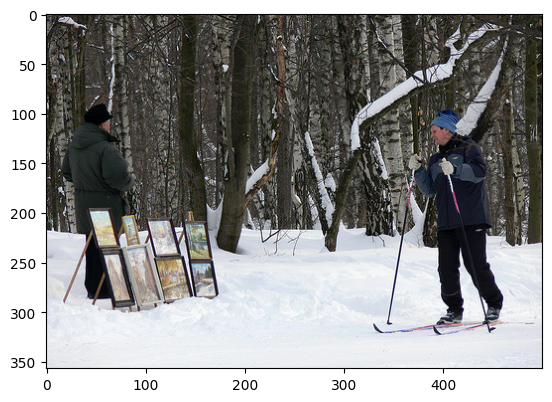

In [43]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq boy dressed in plaid kilt with brown hat wields long pole endseq
startseq boy wearing scottish kilt holding large stick endseq
startseq child is holding rod while standing on bridge near grassy area endseq
startseq little boy in kilt is fishing with stick endseq
startseq young girl dressed in uniform is holding very long stick endseq
--------------------Predicted--------------------
startseq boy wearing red shirt is smiling on the grass endseq


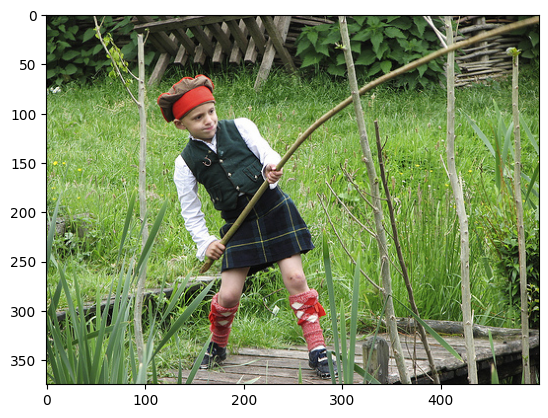

In [44]:
generate_caption("2527163162_d0fb802992.jpg")

---------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted--------------------
startseq little girl grips red stick endseq


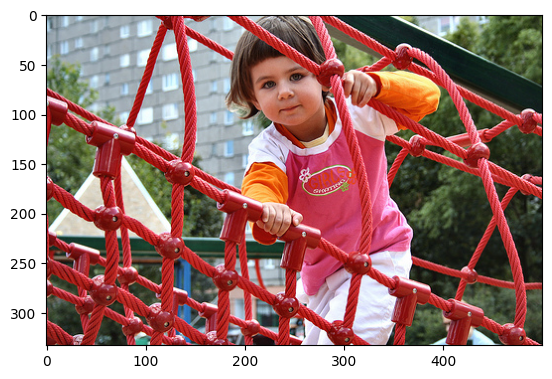

In [45]:
generate_caption("1007320043_627395c3d8.jpg")

---------------------Actual---------------------
startseq black dog and brown dog are jumping up to catch red toy endseq
startseq black dog and brown dog play with red toy on courtyard endseq
startseq brown and black lab are outside and the black lab is catching toy in its mouth endseq
startseq black dog snaps at red and black object as brown dog lunges endseq
startseq the chocolate lab jumps too late to get the toy as the black lab captures it in the driveway endseq
--------------------Predicted--------------------
startseq black lab and brown lab fighting in the grass endseq


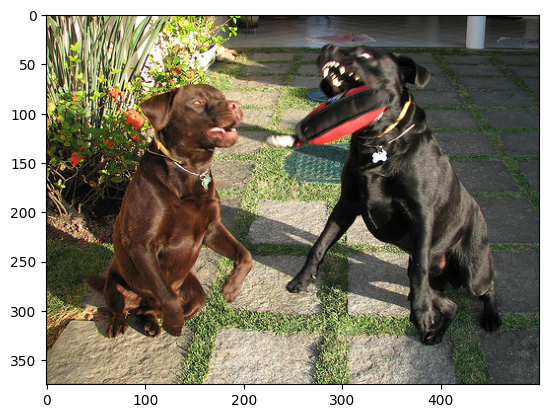

In [46]:
generate_caption("1030985833_b0902ea560.jpg")